In [ ]:
# import some helpful tools
import tools
import random
import copy
import numpy

In [ ]:
# 1D Desription of microstructure evolution
# Show video?
# Discretize space into a series of cell
# Assign a state to each cell
# At every time step local a neeighbourhood is defined to each cell
# A state change rule is applied as a function of the neightbouring cells
# Simulation proceeds in a series of discrete time steps and computing the new states


In [ ]:
liq = 0
solid = 1

In [ ]:
size = 100
n_steps = 100
state = [liq] * size

state[50] = solid
tools.display_state(state)

In [ ]:
state_history = []
temp_state = copy.deepcopy(state)
state_history.append(state)
for n in range(n_steps):
    for cell in range(len(state)):
        if sum(state[cell-1:cell+2]) > 0:
            temp_state[cell] = solid
    state = copy.deepcopy(temp_state)
    state_history.append(state)

In [ ]:
def simulate_growth(size):
    state = [liq] * size
    state[51] = solid
    temp_state = copy.deepcopy(state)
    state_history = [state]
    for dt in range(size):
        for cell in range(size):
            if cell == 0:
                if state[cell+1] == solid:
                    temp_state[cell] = solid
            elif cell == size-1:
                if state[cell-1] == solid:
                    temp_state[cell] = solid
            elif state[cell-1] == solid or state[cell+1] == solid:
                temp_state[cell] = solid
        state = copy.deepcopy(temp_state)
        state_history.append(state)
    return state_history

In [ ]:
state_history = simulate_growth(100)
tools.display_growth(state_history, show_fraction=True)

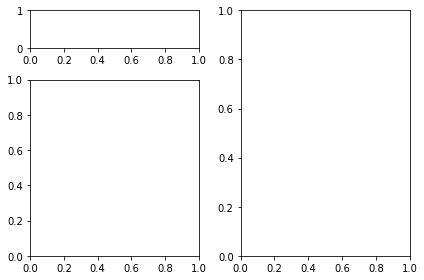

In [29]:
import matplotlib.pyplot as plt
fig=plt.figure()
# (h, v) or (row, column) or (x, y)
ax1 = plt.subplot2grid((4,2),(0, 0))
ax2 = plt.subplot2grid((4,2),(1, 0), rowspan=3)
ax3 = plt.subplot2grid((4,2),(0, 1), rowspan=4, colspan=4)
fig.tight_layout()
plt.show()

In [ ]:
def simulate_growth_2D(size):

    state = numpy.zeros((size, size))
    # Nucleation site
    state[size//2][size//2] = solid
    # Copy state to keep track of history
    temp_state = copy.deepcopy(state)
    state_history = []
    # Loop over each cell
    while numpy.sum(state) < size*size:
        for x in range(size):
            for y in range(size):
                if state[y,x] == solid:
                        temp_state[y-1:y+2, x-1:x+2] = solid


        state = copy.deepcopy(temp_state)
        state_history.append(copy.deepcopy(temp_state))
    return state_history

In [ ]:
state_history = simulate_growth_2D(100)
tools.display_growth(state_history[1], show_fraction=True)

In [ ]:
import cv2
import numpy as np
import random
from math import exp

T = 2
l = 1
m0 = 1
Q = 1
k = 1

p_local = 0.2
p_max = 1
P = p_local / p_max

delta_t = round(T*l / (m0*p_max*exp(-Q/(k*T))))

nsteps = 250
state = np.zeros((nsteps, 1000))
temp = np.zeros((nsteps, 1000))

state[0, :] = np.random.random_sample(state.shape[1]) < 0.02
temp = state

for i in range(1, nsteps):
    for j in range(state.shape[1]):
        if state[i-1, j] == 1:
            temp[i, j] = 1
        elif random.uniform(0,1) < P and np.count_nonzero(state[i-1, j-1:j+2]):
            if i+delta_t >= temp.shape[0]:
                temp[temp.shape[0]-1, j] = 1
            else:
                temp[i+delta_t, j] = 1
        else:
            pass
    state[i] = temp[i]

    cv2.imshow("", state)
    cv2.waitKey(100)
cv2.destroyAllWindows()

In [ ]:

import cv2
import numpy as np
import copy

nc_x = nc_y = 100
nc = nc_x * nc_y

unrec = 0
rec = 1

# neighborhood = "von Neumann"
neighborhood = "Moore"

state = np.random.random_sample((nc_x,nc_y)) < 0.001
state = state.astype('uint8')


while np.all(state) == False:

    temp = copy.deepcopy(state)

    cv2.imshow("", state*255)
    cv2.waitKey(100)

    for x in range(state.shape[1]):
        for y in range(state.shape[0]):

            if state[y,x] == rec:
                if neighborhood == "Moore":
                    temp[y-1:y+2, x-1:x+2] = rec

                if neighborhood == "von Neumann":
                    temp[y-1:y+2, x] = rec
                    temp[y, x-1:x+2] = rec


    state = copy.deepcopy(temp)

cv2.destroyAllWindows()


In [ ]:
# from math import *
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
# import matplotlib.animation as animation

# fig = plt.figure(figsize=(8,6))
# ax = plt.axes(projection='3d')

# N=10
# #val1 = 500

# x=500*np.random.random(N)
# y=500*np.random.random(N)

# z=500*np.random.random(N)

# def frame(w):
#     ax.clear()

#     global x,y,z
#     x=x+np.random.normal(loc=0.0,scale=50.0,size=10)
#     y=y+np.random.normal(loc=0.0,scale=50.0,size=10)
#     z=z+np.random.normal(loc=0.0,scale=50.0,size=10)


#     plt.title("Brownian Motion")
#     ax.set_xlabel('X(t)')
#     ax.set_xlim3d(-500.0,500.0)
#     ax.set_ylabel('Y(t)')
#     ax.set_ylim3d(-500.0,500.0)
#     ax.set_zlabel('Z(t)')

#     ax.set_zlim3d(-500.0,500.0) 
#     plot=ax.scatter3D(x, y, z, c='r')
#     return plot


# anim = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)

# anim.save('BrowniamMotion.gif', writer = "pillow", fps=10 )

# """## Adapt to Colab"""

# from matplotlib import rc
# rc('animation', html='jshtml')

# from math import *
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
# import matplotlib.animation as animation

# fig = plt.figure(figsize=(8,6))
# ax = plt.axes(projection='3d')

# N=10
# x=500*np.random.random(N)
# y=500*np.random.random(N)
# z=500*np.random.random(N)

# def frame(w):
#     ax.clear()
#     global x,y,z
#     x=x+np.random.normal(loc=0.0,scale=50.0,size=10)
#     y=y+np.random.normal(loc=0.0,scale=50.0,size=10)
#     z=z+np.random.normal(loc=0.0,scale=50.0,size=10)

#     plt.title("Brownian Motion")
#     ax.set_xlabel('X(t)')
#     ax.set_xlim3d(-500.0,500.0)
#     ax.set_ylabel('Y(t)')
#     ax.set_ylim3d(-500.0,500.0)
#     ax.set_zlabel('Z(t)')
#     ax.set_zlim3d(-500.0,500.0) 
#     plot=ax.scatter3D(x, y, z, c='r')
#     return plot

# anim = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)

anim